In [2]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [3]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [4]:
#Load shapefile

my_shapefile_path = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [29]:
#Access to Mapillary API

clienttoken = "MLY|6271859919532158|486bcdece7a665eb89a5803f2994b4c9"
clientsecret = "MLY|6271859919532158|891f85315dab6cea6fce4efaac3f1683"
#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)


                    ID                   geometry
0     1294993190897927  POINT (12.54497 55.67563)
1     1438415719828506  POINT (12.55136 55.67272)
2     1515068952168682  POINT (12.55523 55.67405)
3     1835061999993874  POINT (12.54327 55.66779)
4     1910506725763234  POINT (12.56012 55.66256)
...                ...                        ...
1972  4426251814131270  POINT (12.54562 55.67169)
1973  2974528326165199  POINT (12.56064 55.66304)
1974  1307448536465214  POINT (12.54232 55.66404)
1975  1677590685781162  POINT (12.55693 55.66850)
1976  3518888258323053  POINT (12.56295 55.67335)

[1977 rows x 2 columns]


In [6]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

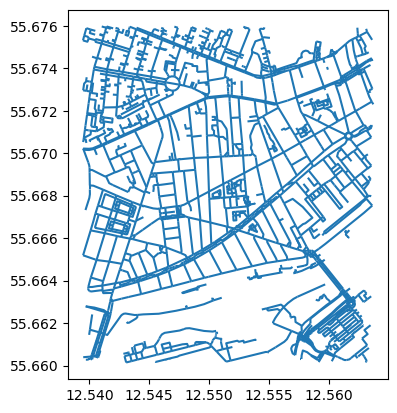

In [7]:

df_lines["geometry"].plot()

/tmp/ipykernel_85868/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

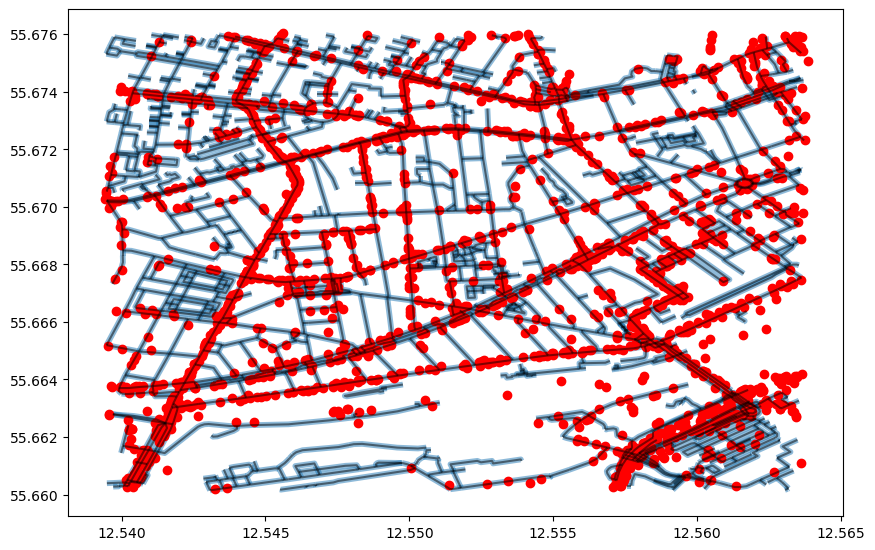

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_85868/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_85868/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


263


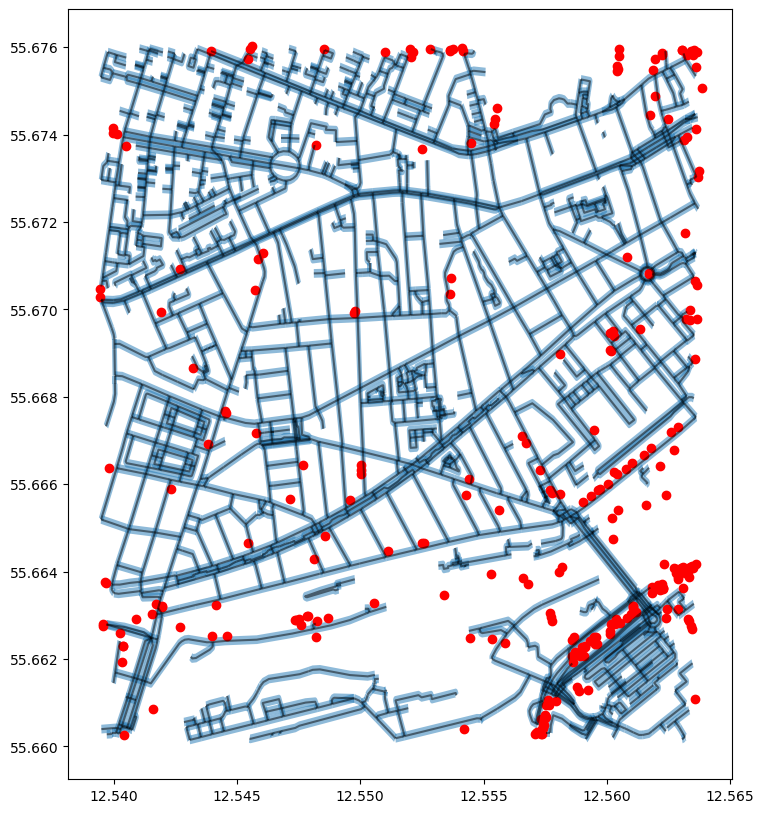

In [9]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [10]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1275896133177758,POINT (12.55524 55.66773),6640.0,174476139.0
0,1275896133177758,POINT (12.55524 55.66773),12286.0,174475183.0
0,1275896133177758,POINT (12.55524 55.66773),45956.0,174476143.0
0,1275896133177758,POINT (12.55524 55.66773),201230.0,174476140.0
1,1691806911014676,POINT (12.56054 55.66616),111090.0,174475738.0
...,...,...,...,...
1978,3034468603358724,POINT (12.54088 55.67396),249753.0,174474306.0
1979,3099615693650681,POINT (12.54246 55.66308),111244.0,174472792.0
1980,3165616257089124,POINT (12.54168 55.66238),15359.0,174472780.0
1980,3165616257089124,POINT (12.54168 55.66238),250333.0,174472782.0


<Axes: >

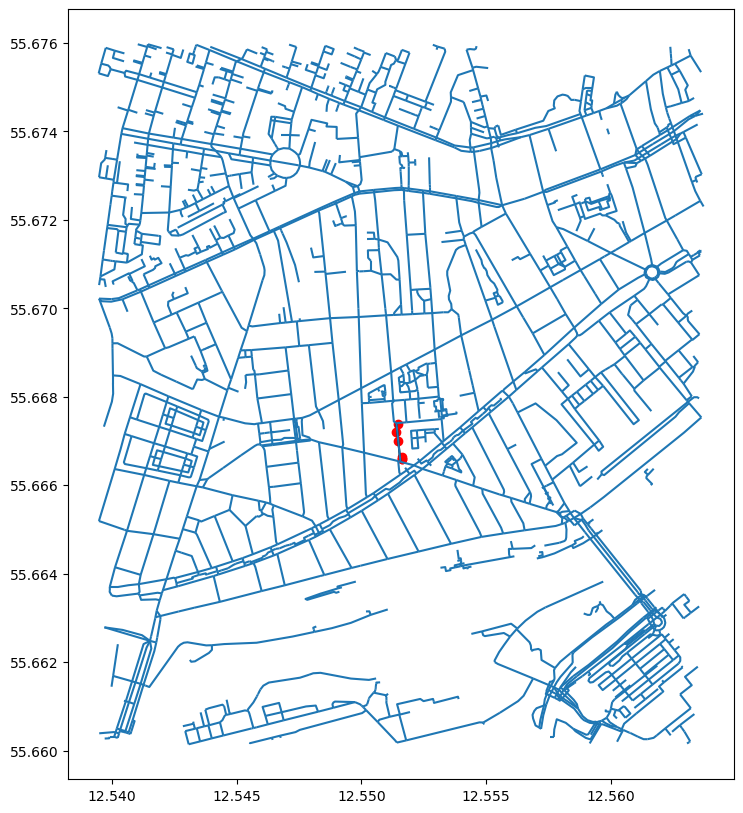

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

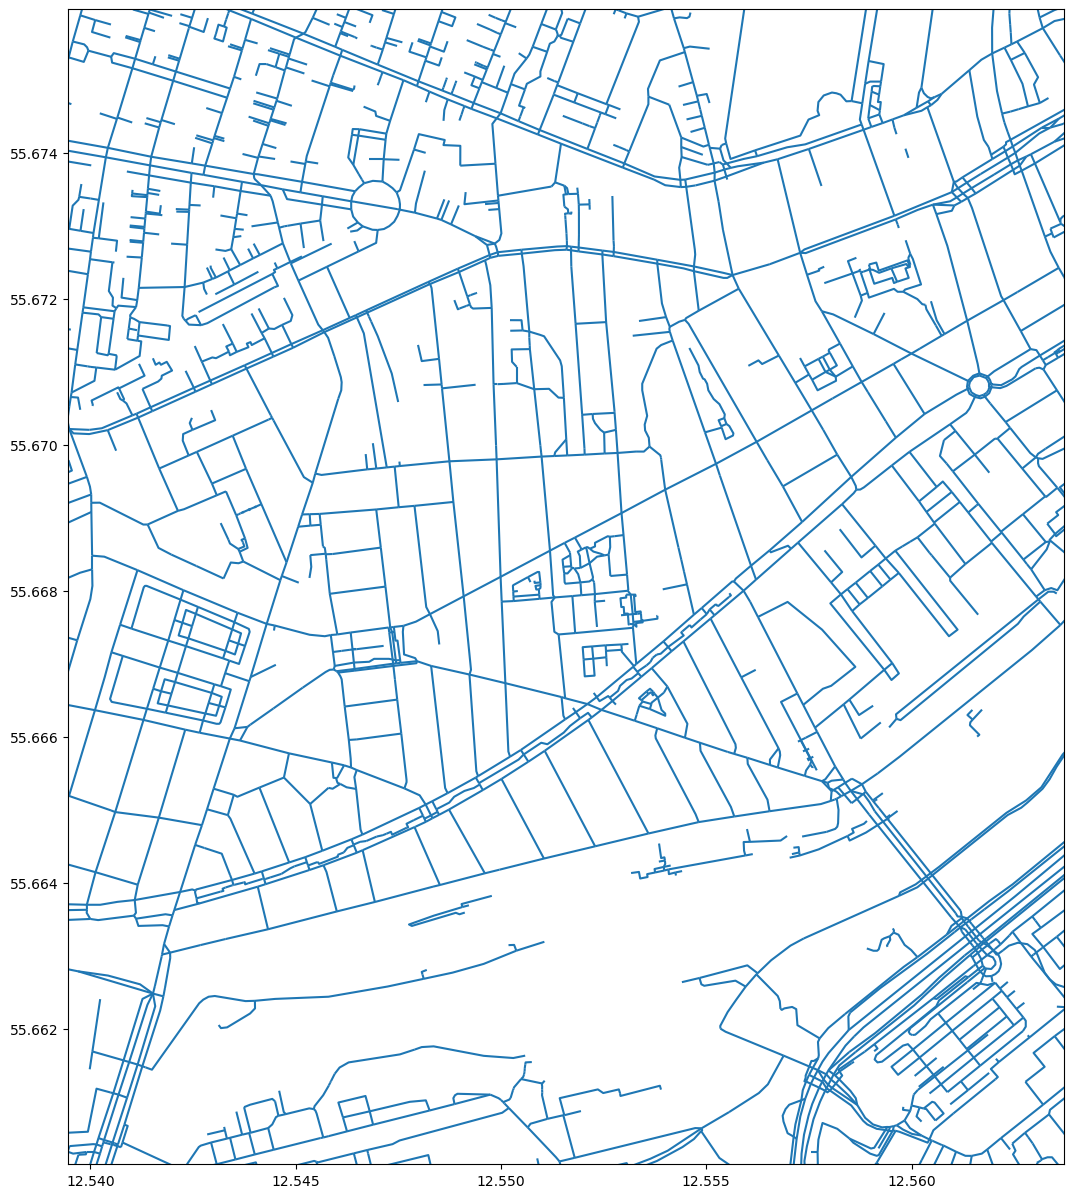

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [13]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [24]:

#print(strava_csv)

csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("sum")
collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))

print(activity_df)


          edge_uid  activity_type    month  total_trip_count  \
0        174191466  Run,Walk,Hike  2022-02                 5   
1        174191466  Run,Walk,Hike  2022-03                 5   
2        174191466  Run,Walk,Hike  2022-04                 5   
3        174314904  Run,Walk,Hike  2022-06                 5   
4        174314904  Run,Walk,Hike  2022-02                 5   
...            ...            ...      ...               ...   
1669274  174686879  Run,Walk,Hike  2022-08                 5   
1669275  174687296  Run,Walk,Hike  2022-01                 5   
1669276  174687296  Run,Walk,Hike  2022-07                 5   
1669277  174687605  Run,Walk,Hike  2022-02                 5   
1669278  174773414  Run,Walk,Hike  2022-08                 5   

         forward_trip_count  reverse_trip_count  forward_people_count  \
0                         5                   5                     5   
1                         5                   0                     5   
2           

In [15]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1275896133177758,POINT (12.55524 55.66773),12286.0,174475183.0,174475183,1140
1,1275896133177758,POINT (12.55524 55.66773),45956.0,174476143.0,174476143,9385
2,3401494656844169,POINT (12.55557 55.66784),45956.0,174476143.0,174476143,9385
3,3357169417845976,POINT (12.55565 55.66791),45956.0,174476143.0,174476143,9385
4,2467218420090156,POINT (12.55563 55.66785),45956.0,174476143.0,174476143,9385
...,...,...,...,...,...,...
2473,2851707871812237,POINT (12.55149 55.66792),129112.0,174475952.0,174475952,195
2474,1333800584141220,POINT (12.54201 55.66361),20910.0,174472796.0,174472796,19700
2475,1413024679033524,POINT (12.56202 55.66862),101029.0,174476820.0,174476820,345
2476,2881440428737867,POINT (12.55097 55.67426),90912.0,174476330.0,174476330,1145


In [16]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [26]:
'''
result = merged_df.drop_duplicates(['ID_left'],keep='first')
result
reset = result.reset_index()
reset.pop("index")
reset
#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)
#print(dataframe2)
'''

'\nresult = merged_df.drop_duplicates([\'ID_left\'],keep=\'first\')\nresult\nreset = result.reset_index()\nreset.pop("index")\nreset\n#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)\n#print(dataframe2)\n'

In [ ]:


list_image_id = merged_df["ID_left"].to_list()

clienttoken = "MLY|6271859919532158|486bcdece7a665eb89a5803f2994b4c9"
clientsecret = "MLY|6271859919532158|891f85315dab6cea6fce4efaac3f1683"
#URL for getting only images within the chosen boundaries


ID_image = []
detection = []

for i in range(0,len(list_image_id)):
    url = f"https://graph.mapillary.com/{list_image_id[i]}/detections?access_token={clienttoken}&fields=image,value"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid og bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    for i in range(0,len(images)):
        try:
            val = str(images[i]["value"])
            detection.append(val)
            ID = str(images[i]["id"])
            ID_image.append(ID)
        except KeyError:
            continue
print((ID_image,detection))
            
    
'''
url = f"https://graph.mapillary.com/4426251814131270/detections?access_token={clienttoken}&fields=image,value"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

values = []
ID = []
for i in range(0,len(images)):
    try:
        val = images[i]["value"]
        values.append(val)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
        
print(values)
'''